In [24]:
import os
import slippi
import re
import pandas as pd
import numpy as np
import pyparsing as parse
import datetime
# This comes from py-slippi, a fanmade package for parsing SSBM games played on the Slippi Emulator
from slippi.parse import ParseEvent
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
path = r"C:\Users\pleasework\Documents\Slippi"
test_path = (path + "\Game_20200630T174259.slp")

I use these scripts to create text files, which I will then extract information about my own playstyle from. The following line requires the slippi-js package, which is the javascript equivalent of py-slippi, except with different implementation(different contributors providing different details). Using all recorded games I have, I hope to be able to find interesting insights into how I play the game that I would not normally realize.
Things I look into: What moves I have a bias for and find success with, what moves work on me, my win ratio on certain matchups (one specific character vs. another specific character)

In [26]:
os.system(f'cmd /k "node slippiStats.js {test_path}>tempData.txt"')

0

In [27]:
from contextlib import redirect_stdout
with open('tempData2.txt', 'w') as d:
    with redirect_stdout(d):
        print(slippi.parse(test_path, {ParseEvent.FRAME: print}))
with open('metaData.txt', 'w') as m:
    with redirect_stdout(m):
        print(slippi.parse(test_path, {ParseEvent.METADATA: print}))

In [28]:
tempConversionData = open("tempData.txt").read()
tempDetailedData = open("tempData2.txt").read()
metaData = open("metaData.txt").read()

In [29]:
stocksTaken = []
lastHit = []

In [30]:
playerNames = re.findall("name=\w*", metaData)
# Ignores first result of "console_name=None"
playerNames = playerNames[1:]
playerNames = [name.replace('name=', '') for name in playerNames]

In [31]:
characters = re.findall(r':\D*:', metaData)

characters = [character.replace(':', '') for character in characters]

In [32]:
playerConversions = [x.group() for x in re.finditer(r"conversions: \[\s*(\s*\{\s*(\w*: .*,?\s*)*},?\s)*", tempConversionData)]

In [33]:
# slippi-js does not include the move used, so we will take the frame(essentially  index) to find 
# what happened from the data generated by py-slippi
frameIndices = re.findall("(?:startFrame:) \d{1,5}", playerConversions[0])
# for convenience down the road, replacing startFrame: with index=
# trying it out with whitespace again
frameIndices = [frame.replace('startFrame: ', '') for frame in frameIndices]
playerConverting = re.findall("(?:playerIndex:) (0|1)", playerConversions[0])
openingType = re.findall(r"openingType: \'.*\'", playerConversions[0])
openingType = [opening.replace('openingType: ', '') for opening in openingType]
openingType = [opening.strip("\'") for opening in openingType]

In [34]:
# What's next is to take the frame indices, and find the move used. Then you gotta make sure it does it
# for all your games

In [35]:
characterConverting = [characters[0] if player == '0' else characters[1] for player in playerConverting]

In [36]:
conversionCharacterAndFrame = dict(zip(frameIndices, characterConverting))

In [37]:
comma = ','
colon = ':'
moveNums = parse.Word(parse.nums) + parse.Optional(parse.Word(parse.nums))
frames = parse.Literal('index=') + parse.oneOf(frameIndices) + comma
attackDirection = parse.oneOf(["B", "D", "F", "N", "U", "SIDE_", "NEUTRAL_", "UP_", "DOWN_"])
attackChoice = parse.oneOf(["AIR", "TILT", "SMASH", "JAB", "B", "THROW", "JAB_2", "JAB_3", "JAB_4"])

In [38]:
killCount = parse.Literal('killCount:').suppress() + parse.Word(parse.nums)

In [39]:
for match in killCount.scanString(tempConversionData):
    stocksTaken.append(match[0][0])

In [40]:
stocksTaken

['4', '3']

In [41]:
metaData = {'PlayerTag': playerNames, 'Characters': characters, 'Winner': stocksTaken}

metaDF = pd.DataFrame(data=metaData)

In [42]:
metaDF['Winner'] = np.where(metaDF['Winner'] == '4', 'Winner', 'Loser')

In [43]:
metaDF

,PlayerTag,Characters,Winner
0,2Chans,MARTH,Winner
1,fycRoman,CAPTAIN_FALCON,Loser


In [44]:
# Missing: 2283, there's no last attack landed, possible inconsistency between scripts?

In [45]:
# Make pyparsing keep a cache of the string 
parse.ParserElement.enablePackrat

<function pyparsing.ParserElement.enablePackrat(cache_size_limit=128)>

In [46]:
start = datetime.datetime.now()
lastHit = []
for frame in frameIndices:
    currChar = conversionCharacterAndFrame[frame]
    tempParser = parse.Combine(parse.Literal('index=').suppress()+ frame + comma
                               + parse.SkipTo(currChar).suppress() +
                              parse.Literal(currChar).suppress() 
                               + parse.SkipTo('last_attack_landed=').suppress()
                            +parse.Literal('last_attack_landed=').suppress()
                            +parse.Word(parse.nums).suppress()+colon+parse.Optional(attackDirection) + attackChoice)
    attackLanded = tempParser.searchString(tempDetailedData, maxMatches=1)
    try:
        lastHit.append(attackLanded[0][0])
    # Sometimes, the data doesn't include the last attack landed (not clear why), so this will account for it
    except IndexError:
        pass
    
    ### Make it so that scanString starts from where previous left off
print("Time Taken = ", datetime.datetime.now() - start)

Time Taken =  1:26:27.312991


In [47]:
test = lastHit.copy()
lastHit = np.array([hit.split(',:') for hit in lastHit])

In [48]:
hitDF = pd.DataFrame(lastHit)

In [49]:
hitDF.rename(columns = {0: 'Frames', 1: 'Attack'}, inplace=True)

In [50]:
hitDF

,Frames,Attack
0,556,FAIR
1,691,NAIR
2,1009,FTILT
3,1177,JAB_2
4,1930,BAIR
5,2522,DTILT
6,2740,NAIR
7,2817,NAIR
8,2928,UAIR
9,3592,FAIR


In [51]:
conversionDF = pd.DataFrame()

In [52]:
conversionDF = conversionDF.assign(Frames = frameIndices)

In [53]:
conversionDF = conversionDF.assign(PlayerConverting = playerConverting)

In [54]:
conversionDF = pd.merge(conversionDF, hitDF, on = 'Frames', how = 'outer')

In [55]:
conversionDF['Character'] = np.where(conversionDF['PlayerConverting'] == '0', characters[0], characters[1])

In [56]:
conversionDF['PlayerConverting'] = np.where(conversionDF['PlayerConverting'] == '0', playerNames[0], playerNames[1])

In [57]:
conversionDF['OpeningType'] = openingType

In [100]:
myConversions = conversionDF[conversionDF['PlayerConverting'] == '2Chans']
others = conversionDF[conversionDF['PlayerConverting'] != '2Chans']

In [103]:
myConversions.reset_index(inplace=True, drop=True)
others.reset_index(inplace=True, drop=True)

Text(0.5, 1.0, 'MARTH(ME) VS. CAPTAIN_FALCON Move Choices as Percentage of Neutral Wins')

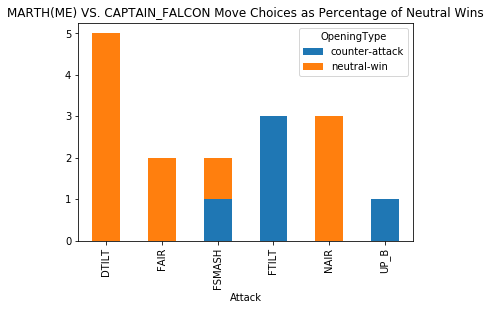

In [108]:
myChar = metaDF['Characters'][0]
theirChar = others['Character'][0]
myConversionsPlot = myConversions.groupby(['Attack', 'OpeningType']).size().unstack().plot(kind='bar', stacked=True)
myConversionsPlot.set_title(myChar + '(ME) VS. ' + theirChar + ' Move Choices as Percentage of Neutral Wins')

Text(0.5, 1.0, 'CAPTAIN_FALCON VS. MARTH(ME) Move Choices as Percentage of Neutral Wins')

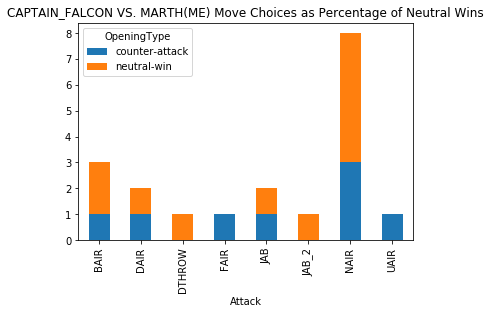

In [109]:
theirConversionsPlot = others.groupby(['Attack', 'OpeningType']).size().unstack().plot(kind='bar', stacked=True)
theirConversionsPlot.set_title(theirChar + ' VS. ' + myChar + '(ME) Move Choices as Percentage of Neutral Wins')

In [39]:
metaDF

,PlayerTag,Characters,Winner
0,2Chans,MARTH,Winner
1,fycRoman,CAPTAIN_FALCON,Loser


For future improvements, I'm thinking about making this a python script as there might be something with Jupyter that causes parsing to take longer than expected. I also plan on analyzing multiple games, and I'm considering using a dictionary of dictionaries in order to keep track of the different dataframes 
The expected hierarchy being like:
    {Game 1: {MetaData, Char1Conversion, Char2Conversion},
     Game 2: ....}
If I choose to analyze multiple games at once, I plan on doing some kind of analysis on my success rate on certain character matchups, and what my biases are.